In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='monospace')

In [2]:
df = pd.read_csv('data_wo_outliers.csv', index_col=0)

In [3]:
df.drop(columns=['name'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031 entries, 0 to 1556
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wins            1031 non-null   int64  
 1   kills           1031 non-null   int64  
 2   kdRatio         1031 non-null   float64
 3   killstreak      1031 non-null   int64  
 4   level           1031 non-null   int64  
 5   losses          1031 non-null   int64  
 6   prestige        1031 non-null   int64  
 7   hits            1031 non-null   int64  
 8   timePlayed      1031 non-null   int64  
 9   headshots       1031 non-null   int64  
 10  averageTime     1031 non-null   float64
 11  gamesPlayed     1031 non-null   int64  
 12  assists         1031 non-null   int64  
 13  misses          1031 non-null   int64  
 14  xp              1031 non-null   int64  
 15  scorePerMinute  1031 non-null   float64
 16  shots           1031 non-null   int64  
 17  deaths          1031 non-null   int64 

## Preliminary Analysis

---

- How might we predict `kdRatioAlt`?
- How might we predict `winRateAlt`?

### Suggested Predictors

- `level`
- `prestige`
- `xp`
- `hitRate`
- `timePlayed`
- `averageTime`
- `gamesPlayed`
- `headshotRate`
- `assistsPerGame`

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [6]:
def model_evaluation(df, predictors, target, model_instance):
    df_train, df_test = train_test_split(df, test_size=0.2)

    pipeline = Pipeline([
        ('Standardization', StandardScaler()),
        ('Regression', model_instance),
    ])
    
    model = pipeline.fit(df_train[predictors], df_train[[target]])
    
    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])
    r2_train, mse_test = r2_score(df_train[[target]], pred_train), mean_squared_error(df_test[[target]], pred_test)

    print(f'r2 (Train Set)\t{r2_train:.3f}')
    print(f'MSE (Test Set)\t{mse_test:.3f}')

    return r2_train, mse_test

In [7]:
def plot_correlation_heatmap(data, variables, cmap):
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    axes.set_title('Correlation Heatmap', fontsize=20)
    sns.heatmap(data=data[variables].corr(), annot=True, fmt='.2f', linewidth=1.5, ax=axes, cmap=cmap)

In [8]:
def model_evaluation_w_grid_search(df, predictors, target, model_instance, param_grid, cv):
    df_train, df_test = train_test_split(df, test_size=0.2)
    
    pipeline = Pipeline([
        ('Standardization', StandardScaler()),
        ('Regression', model_instance),
    ])
    
    model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='r2')
    model.fit(df_train[predictors], df_train[[target]])
    
    print('<<- Grid Search Results (Best Parameters) ->>\n')
    for k, v in model.best_params_.items():
        print(f'{k[12:]:10}\t{v}')
    print()
    
    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])
    r2_train, mse_test = r2_score(df_train[[target]], pred_train), mean_squared_error(df_test[[target]], pred_test)
    
    print('<<- Regression Results ->>\n')
    print(f'r2 (Train Set)\t{r2_train:.3f}')
    print(f'MSE (Test Set)\t{mse_test:.3f}')

    return r2_train, mse_test

In [9]:
model_performance = {'kdRatioAlt': {}, 'winRateAlt': {}}

## Linear Regression

Before looking at other regression techniques, we'll first explore the correlations between different variables and conduct
Linear Regression.

---

### **Target Variable**: `kdRatioAlt`

In [10]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'kdRatioAlt'

In [11]:
correlations = [np.corrcoef(df[pred], df[target])[0][1] for pred in predictors]

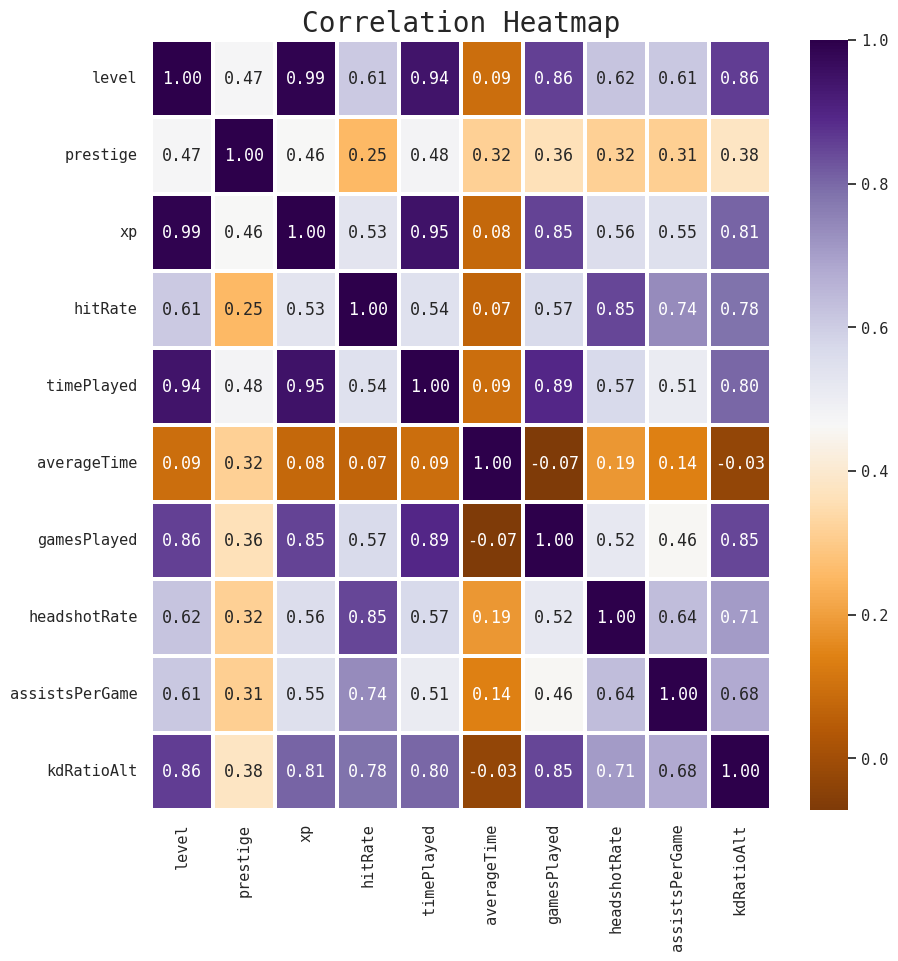

In [12]:
plot_correlation_heatmap(data=df, variables=predictors+[target], cmap='PuOr')

In [13]:
print('<<- Predictors Ranked ->>\n')
for corr, pred in sorted(zip(correlations, predictors)):
    print(f'{pred:10}\t{corr:+.3f}')

<<- Predictors Ranked ->>

averageTime	-0.029
prestige  	+0.379
assistsPerGame	+0.679
headshotRate	+0.708
hitRate   	+0.784
timePlayed	+0.800
xp        	+0.806
gamesPlayed	+0.848
level     	+0.860


> It appears that `level`, `gamesPlayed`, and `xp` are the most correlated with `kdRatioAlt`.

In [14]:
predictors_top_3 = [i[1] for i in sorted(zip(correlations, predictors))[-3:]]
print(predictors_top_3)

['xp', 'gamesPlayed', 'level']


In [15]:
predictor_performance = {'predictor': [], 'MSE (Test Set)': []}

In [16]:
print('<<- Univariate Prediction ->>')
for pred in predictors:
    print(f'\n|> {pred}')
    _, mse = model_evaluation(df=df, predictors=[pred], target=target, model_instance=LinearRegression())
    predictor_performance['predictor'].append(pred)
    predictor_performance['MSE (Test Set)'].append(mse)

<<- Univariate Prediction ->>

|> level
r2 (Train Set)	0.761
MSE (Test Set)	1.336

|> prestige
r2 (Train Set)	0.133
MSE (Test Set)	2.631

|> xp
r2 (Train Set)	0.657
MSE (Test Set)	1.534

|> hitRate
r2 (Train Set)	0.621
MSE (Test Set)	1.435

|> timePlayed
r2 (Train Set)	0.638
MSE (Test Set)	1.313

|> averageTime
r2 (Train Set)	0.002
MSE (Test Set)	3.668

|> gamesPlayed
r2 (Train Set)	0.724
MSE (Test Set)	1.072

|> headshotRate
r2 (Train Set)	0.490
MSE (Test Set)	1.644

|> assistsPerGame
r2 (Train Set)	0.473
MSE (Test Set)	2.396


> In terms of univariate prediction, `gamesPlayed` is the best predictor, yielding the lowest MSE.

In [17]:
print('<<- Multivariate Prediction ->>')

print('\n|> All 9')
_, mse = model_evaluation(df=df, predictors=predictors, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('All 9')
predictor_performance['MSE (Test Set)'].append(mse)

print('\n|> Top 3')
_, mse = model_evaluation(df=df, predictors=predictors_top_3, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('Top 3')
predictor_performance['MSE (Test Set)'].append(mse)

<<- Multivariate Prediction ->>

|> All 9
r2 (Train Set)	0.909
MSE (Test Set)	0.314

|> Top 3
r2 (Train Set)	0.878
MSE (Test Set)	0.555


> Using all nine predictors for regression performs better than using just the top three predictors with
> the highest correlation with `kdRatioAlt`.

In [18]:
pairs = sorted((predictor_performance['MSE (Test Set)'][i],
                predictor_performance['predictor'][i]) for i in range(len(predictor_performance['predictor'])))
predictor_performance['predictor'] = [pair[1] for pair in pairs]
predictor_performance['MSE (Test Set)'] = [pair[0] for pair in pairs]

(0.0, 4.767860414954688)

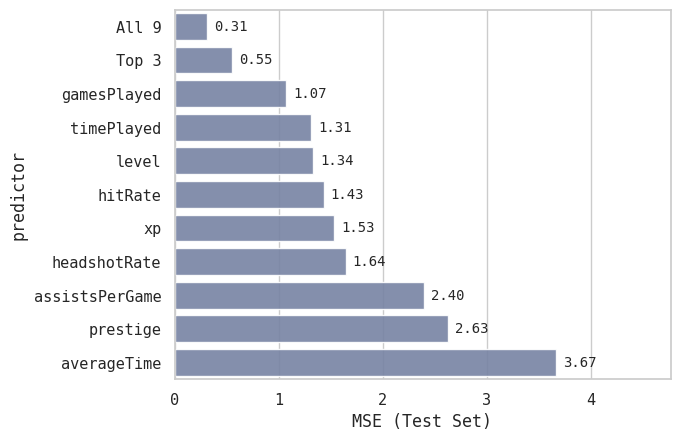

In [19]:
ax = sns.barplot(data=pd.DataFrame(predictor_performance),
                 x='MSE (Test Set)',
                 y='predictor',
                 orient='y',
                 color='#7080aa',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, predictor_performance['MSE (Test Set)'][-1] * 1.3)

> As elucidated in this graph, using *all nine* predictors via a multivariate regression yields the best results.

In [20]:
model_performance[target]['LinearRegression'] = predictor_performance['MSE (Test Set)'][0]

### **Target Variable**: `winRateAlt`

In [21]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'winRateAlt'

In [22]:
correlations = [np.corrcoef(df[pred], df[target])[0][1] for pred in predictors]

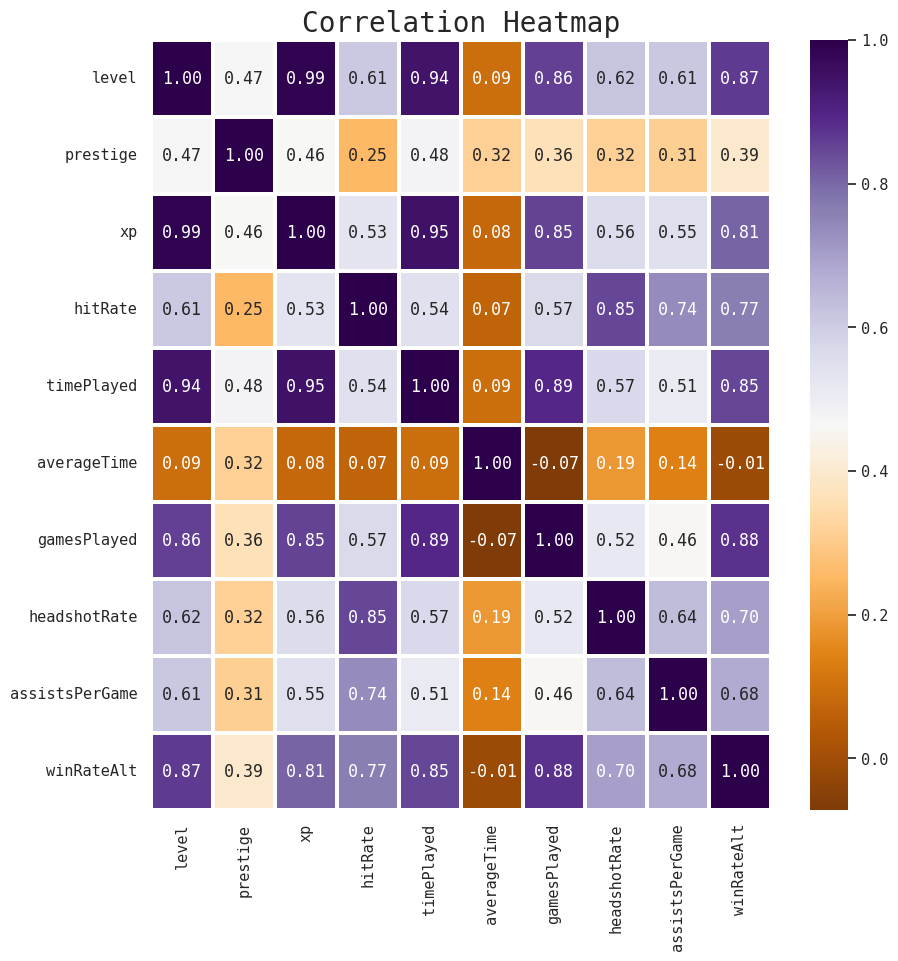

In [23]:
plot_correlation_heatmap(data=df, variables=predictors+[target], cmap='PuOr')

In [24]:
print('<<- Predictors Ranked ->>\n')
for corr, pred in sorted(zip(correlations, predictors)):
    print(f'{pred:10}\t{corr:+.3f}')

<<- Predictors Ranked ->>

averageTime	-0.010
prestige  	+0.395
assistsPerGame	+0.679
headshotRate	+0.701
hitRate   	+0.765
xp        	+0.807
timePlayed	+0.847
level     	+0.866
gamesPlayed	+0.876


In [25]:
predictors_top_3 = [i[1] for i in sorted(zip(correlations, predictors))[-3:]]
print(predictors_top_3)

['timePlayed', 'level', 'gamesPlayed']


In [26]:
predictor_performance = {'predictor': [], 'MSE (Test Set)': []}

In [27]:
print('<<- Univariate Prediction ->>')
for pred in predictors:
    print(f'\n|> {pred}')
    _, mse = model_evaluation(df=df, predictors=[pred], target=target, model_instance=LinearRegression())
    predictor_performance['predictor'].append(pred)
    predictor_performance['MSE (Test Set)'].append(mse)

<<- Univariate Prediction ->>

|> level
r2 (Train Set)	0.750
MSE (Test Set)	0.947

|> prestige
r2 (Train Set)	0.139
MSE (Test Set)	2.908

|> xp
r2 (Train Set)	0.656
MSE (Test Set)	1.215

|> hitRate
r2 (Train Set)	0.599
MSE (Test Set)	1.658

|> timePlayed
r2 (Train Set)	0.714
MSE (Test Set)	1.007

|> averageTime
r2 (Train Set)	0.000
MSE (Test Set)	3.989

|> gamesPlayed
r2 (Train Set)	0.774
MSE (Test Set)	0.912

|> headshotRate
r2 (Train Set)	0.490
MSE (Test Set)	1.809

|> assistsPerGame
r2 (Train Set)	0.467
MSE (Test Set)	2.044


In [28]:
print('<<- Multivariate Prediction ->>')

print('\n|> All 9')
_, mse = model_evaluation(df=df, predictors=predictors, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('All 9')
predictor_performance['MSE (Test Set)'].append(mse)

print('\n|> Top 3')
_, mse = model_evaluation(df=df, predictors=predictors_top_3, target=target, model_instance=LinearRegression())
predictor_performance['predictor'].append('Top 3')
predictor_performance['MSE (Test Set)'].append(mse)

<<- Multivariate Prediction ->>

|> All 9
r2 (Train Set)	0.945
MSE (Test Set)	0.220

|> Top 3
r2 (Train Set)	0.821
MSE (Test Set)	0.701


In [29]:
pairs = sorted((predictor_performance['MSE (Test Set)'][i],
                predictor_performance['predictor'][i]) for i in range(len(predictor_performance['predictor'])))
predictor_performance['predictor'] = [pair[1] for pair in pairs]
predictor_performance['MSE (Test Set)'] = [pair[0] for pair in pairs]

(0.0, 5.185902771512056)

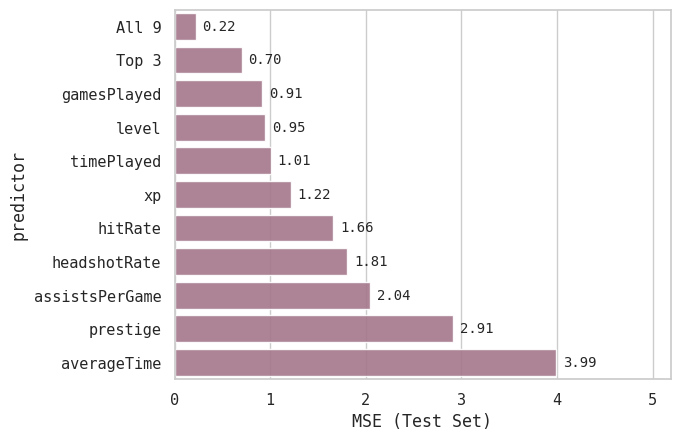

In [30]:
ax = sns.barplot(data=pd.DataFrame(predictor_performance),
                 x='MSE (Test Set)',
                 y='predictor',
                 orient='y',
                 color='#aa708a',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, predictor_performance['MSE (Test Set)'][-1] * 1.3)

> Using all nine predictors is also preferable in the context of `winRateAlt`.

In [31]:
model_performance[target]['LinearRegression'] = predictor_performance['MSE (Test Set)'][0]

## Other Models (W/ Grid Search)

---

> Because multivariate regression on all nine predictors has proven to be most effective, we will continue to use all nine predictors
> for our subsequent regression models.

In this section, we also leverage the **5-fold cross validation grid search** to determine the best combination of hyperparamters.

### **Target Variable**: `kdRatioAlt`

In [32]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'kdRatioAlt'

In [33]:
param_grid = {
    'Regression__alpha':    [0.1, 1, 10, 100],
    'Regression__tol':      [1e-3, 1e-4, 1e-5, 1e-6],
    'Regression__max_iter': [1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=Lasso(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['Lasso'] = mse

<<- Grid Search Results (Best Parameters) ->>

alpha     	0.1
max_iter  	1000
tol       	0.001

<<- Regression Results ->>

r2 (Train Set)	0.878
MSE (Test Set)	0.416


In [34]:
param_grid = {
    'Regression__C':        [1.0, 2.0, 3.0, 4.0, 5.0],
    'Regression__tol':      [1e-3, 1e-4, 1e-5],
    'Regression__max_iter': [-1, 1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVR(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['SVR'] = mse

<<- Grid Search Results (Best Parameters) ->>

C         	2.0
max_iter  	1000
tol       	0.0001

<<- Regression Results ->>

r2 (Train Set)	0.961
MSE (Test Set)	0.297


In [35]:
param_grid = {
    'Regression__n_neighbors': [5, 10, 15, 20, 25],
    'Regression__leaf_size':   [5, 15, 30, 45],
    'Regression__weights':     ['uniform', 'distance']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['KNeighborsRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

leaf_size 	5
n_neighbors	15
weights   	distance

<<- Regression Results ->>

r2 (Train Set)	1.000
MSE (Test Set)	0.417


In [36]:
param_grid = {
    'Regression__n_estimators': [50, 100, 150],
    'Regression__max_depth':    [None, 5, 10],
    'Regression__max_features': [1, 'sqrt', 'log2']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['RandomForestRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

max_depth 	None
max_features	sqrt
n_estimators	150

<<- Regression Results ->>

r2 (Train Set)	0.992
MSE (Test Set)	0.237


In [37]:
param_grid = {
    'Regression__learning_rate': [0.1, 1, 10],
    'Regression__n_estimators':  [100, 200],
    'Regression__max_depth':     [3, 5, 7]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['GradientBoostingRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

learning_rate	0.1
max_depth 	3
n_estimators	100

<<- Regression Results ->>

r2 (Train Set)	0.986
MSE (Test Set)	0.324


(0.0, 0.5415282172832667)

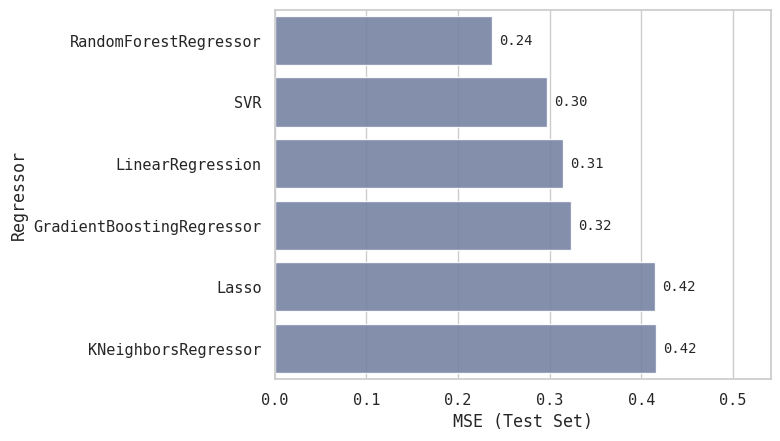

In [38]:
pairs = sorted((v, k) for k, v in model_performance[target].items())
result = {'Regressor': [pair[1] for pair in pairs], 'MSE (Test Set)': [pair[0] for pair in pairs]}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='MSE (Test Set)',
                 y='Regressor',
                 orient='y',
                 color='#7080aa',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, result['MSE (Test Set)'][-1] * 1.3)

> In predicting `kdRatioAlt`, the **Random Forest Regressor** performed the best

### **Target Variable**: `winRateAlt`

In [39]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'winRateAlt'

In [40]:
param_grid = {
    'Regression__alpha':    [0.1, 1, 10, 100],
    'Regression__tol':      [1e-3, 1e-4, 1e-5, 1e-6],
    'Regression__max_iter': [1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=Lasso(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['Lasso'] = mse

<<- Grid Search Results (Best Parameters) ->>

alpha     	0.1
max_iter  	1000
tol       	1e-06

<<- Regression Results ->>

r2 (Train Set)	0.895
MSE (Test Set)	0.378


In [41]:
param_grid = {
    'Regression__C':        [1.0, 2.0, 3.0, 4.0, 5.0],
    'Regression__tol':      [1e-3, 1e-4, 1e-5],
    'Regression__max_iter': [-1, 1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVR(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['SVR'] = mse

<<- Grid Search Results (Best Parameters) ->>

C         	5.0
max_iter  	-1
tol       	0.001

<<- Regression Results ->>

r2 (Train Set)	0.991
MSE (Test Set)	0.047


In [42]:
param_grid = {
    'Regression__n_neighbors': [5, 10, 15, 20, 25],
    'Regression__leaf_size':   [5, 15, 30, 45],
    'Regression__weights':     ['uniform', 'distance']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['KNeighborsRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

leaf_size 	5
n_neighbors	10
weights   	distance

<<- Regression Results ->>

r2 (Train Set)	1.000
MSE (Test Set)	0.159


In [43]:
param_grid = {
    'Regression__n_estimators': [50, 100, 150],
    'Regression__max_depth':    [None, 5, 10],
    'Regression__max_features': [1, 'sqrt', 'log2']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['RandomForestRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

max_depth 	None
max_features	sqrt
n_estimators	150

<<- Regression Results ->>

r2 (Train Set)	0.999
MSE (Test Set)	0.027


In [44]:
param_grid = {
    'Regression__learning_rate': [0.1, 1, 10],
    'Regression__n_estimators':  [100, 200],
    'Regression__max_depth':     [3, 5, 7]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['GradientBoostingRegressor'] = mse

<<- Grid Search Results (Best Parameters) ->>

learning_rate	0.1
max_depth 	3
n_estimators	100

<<- Regression Results ->>

r2 (Train Set)	0.998
MSE (Test Set)	0.017


(0.0, 0.49106911129660213)

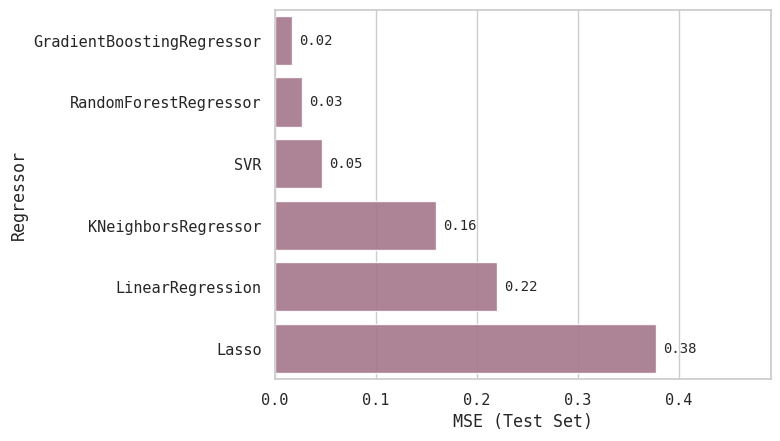

In [45]:
pairs = sorted((v, k) for k, v in model_performance[target].items())
result = {'Regressor': [pair[1] for pair in pairs], 'MSE (Test Set)': [pair[0] for pair in pairs]}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='MSE (Test Set)',
                 y='Regressor',
                 orient='y',
                 color='#aa708a',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, result['MSE (Test Set)'][-1] * 1.3)

> In predicting `winRateAlt`, the **Gradient Boosting Regressor** performed the best.